In [1]:
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch,torchvision
from torch.nn import *
from tqdm import tqdm
import cv2
from torch.optim import *
# Preproccessing
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    OneHotEncoder,
    Normalizer,
    Binarizer
)
# Decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
# Model Eval
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
# Other
import pickle
import wandb

PROJECT_NAME = 'Bitcoin-Time-Series-All-Time'
device = 'cuda:0'
np.random.seed(21)
random.seed(21)
torch.manual_seed(21)

In [2]:
data = pd.read_csv('./cleaned-data.csv')['Close']

In [3]:
# data.to_csv('./cleaned-data.csv')

In [4]:
data = data.tolist()

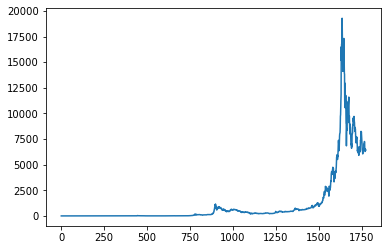

In [5]:
plt.plot(data)

In [6]:
data = torch.from_numpy(np.array(data)).view(1,-1).to(device).float()

In [7]:
data_input = data[:1,:-1].to(device).float()
data_target = data[:1,1:].to(device).float()

In [8]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.hidden = 512
        self.lstm1 = LSTMCell(1,self.hidden).to(device)
        self.lstm2 = LSTMCell(self.hidden,self.hidden).to(device)
        self.linear = Linear(self.hidden,1).to(device)
    
    def forward(self,X,future=0):
        preds = []
        batch_size = X.shape[0]
        h_t1 = torch.zeros(batch_size,self.hidden).to(device)
        c_t1 = torch.zeros(batch_size,self.hidden).to(device)
        h_t2 = torch.zeros(batch_size,self.hidden).to(device)
        c_t2 = torch.zeros(batch_size,self.hidden).to(device)
        for X_batch in X.split(1,dim=1):
            X_batch = X_batch.to(device)
            h_t1,c_t1 = self.lstm1(X_batch,(h_t1,c_t1))
            h_t1 = h_t1.to(device)
            c_t1 = c_t1.to(device)
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            pred = self.linear(h_t2)
            preds.append(pred)
        for _ in range(future):
            h_t1,c_t1 = self.lstm1(X_batch,(h_t1,c_t1))
            h_t1 = h_t1.to(device)
            c_t1 = c_t1.to(device)
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            pred = self.linear(h_t2)
            preds.append(pred)
        preds = torch.cat(preds,dim=1)
        return preds

In [9]:
model = Model().to(device)
model.to(device)
criteiron = MSELoss()
optimizer = Adam(model.parameters(),lr=0.001)
epochs = 1000

In [10]:
wandb.init(project=PROJECT_NAME,name='baseline')
for _ in tqdm(range(epochs)):
    def closure():
        optimizer.zero_grad()
        preds = model(data_input)
        loss = criterion(preds,data_target)
        loss.backward()
        wandb.log({'Loss':loss.item()})
        return loss
    optimizer.step(closure)
    with torch.no_grad():
        future = 100
        preds = model(data_input,future)
        loss = criterion(preds[:,:-future],data_target)
        wandb.log({'Val Loss No Grad':loss.item()})
        preds = preds[0].cpu().view(-1).detach().numpy()
        n = data_input.shape[1]
        plt.figure(figsize=(12,7))
        plt.plot(np.arange(n),data_target.cpu().view(-1).detach().numpy(),'b')
        plt.plot(np.arange(n,n+future),preds[n:],'r')
        plt.savefig('./img_no_grad.png')
        plt.close()
        wandb.log({'Img No Grad':wandb.Image(cv2.imread('/img_no_grad.png'))})
    model.eval()
    with torch.no_grad():
        future = 100
        preds = model(data_input,future)
        loss = criterion(preds[:,:-future],data_target)
        wandb.log({'Val Loss Eval':loss.item()})
        preds = preds[0].cpu().view(-1).detach().numpy()
        n = data_input.shape[1]
        plt.figure(figsize=(12,7))
        plt.plot(np.arange(n),data_target.cpu().view(-1).detach().numpy(),'b')
        plt.plot(np.arange(n,n+future),preds[n:],'r')
        plt.savefig('./img_eval.png')
        plt.close()
        wandb.log({'Img Eval':wandb.Image(cv2.imread('img_eval.png'))})
    model.train()
wandb.finish()

Retry attempt failed:
Traceback (most recent call last):
  File "/home/indika/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 170, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/indika/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/indika/anaconda3/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/indika/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 706, in urlopen
    chunked=chunked,
  File "/home/indika/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 382, in _make_request
    self._valid

Problem at: /tmp/ipykernel_18515/2759248058.py 1 <module>


KeyboardInterrupt: 

Process wandb_internal:
Traceback (most recent call last):
  File "/home/indika/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/indika/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/indika/anaconda3/lib/python3.7/site-packages/wandb/sdk/internal/internal.py", line 152, in wandb_internal
    thread.join()
  File "/home/indika/anaconda3/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/home/indika/anaconda3/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt
